# Use XGBoost to train the data

- Ref 1: https://www.datacamp.com/tutorial/xgboost-in-python
- Ref 2: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

In [1]:
import numpy as np
import pandas as pd

import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.pylab as pl

shap.initjs()

# Load and preprocess the data

In [2]:
MA_AP_all_data = pd.read_csv('data/Massachusetts/AP_data_combined_18_22.csv')

data_MA_inference = MA_AP_all_data.drop(columns=['COUNTY', 'District Code', 'Year', 'Tests Taken'])    ## drop unnecessary columns
data_MA_inference.columns

Index(['PERCENT_3_OR_ABOVE', 'population', 'per_capita_income',
       'closest_five_r1r2_avg', 'closest_five_avg_enrollment_r1r2',
       'closest_five_avg_dormrooms_r1r2', 'closest_five_public_avg',
       'closest_five_avg_enrollment_public',
       'closest_five_avg_dormrooms_public', 'closest_five_private_nfp_avg',
       'closest_five_avg_enrollment_private_nfp',
       'closest_five_avg_dormrooms_private_nfp', 'closest_five_landgrnt_avg',
       'closest_five_avg_enrollment_landgrnt',
       'closest_five_avg_dormrooms_landgrant', 'closest_five_stem_avg',
       'closest_five_avg_enrollment_stem', 'closest_five_avg_dormrooms_stem'],
      dtype='object')

# Split the full data set into the train set and the test set

In [3]:
outcome  = data_MA_inference.columns[0]       ## use the column '% Score 3-5' as the outcome of the model
features = data_MA_inference.columns[1:]      ## all other columns are the features of the model

X = data_MA_inference[features]
y = data_MA_inference[outcome]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=216)

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Use XGBoost to train the model

In [4]:
# params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model

params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "max_depth": 6,            # Example: Tune this parameter
    "learning_rate": 0.1,      # Example: Lower learning rate
    "subsample": 0.8,          # Example: Subsampling for regularization
    "random_state": 216
}

n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:16.20125	validation-rmse:16.94825
[50]	train-rmse:6.65159	validation-rmse:7.82320
[100]	train-rmse:6.54348	validation-rmse:7.78230
[150]	train-rmse:6.53361	validation-rmse:7.86125
[180]	train-rmse:6.53168	validation-rmse:7.90283


In [5]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "random_state": 216}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,13.937669,0.114346,14.348766,0.445378
1,11.534461,0.139256,12.327098,0.457680
2,9.981717,0.134961,11.101497,0.583694
3,8.936042,0.137275,10.359516,0.630816
4,8.159286,0.117140,9.814553,0.614653


### A quick example: use the ``xgb_model`` trained above for predicting AP outcomes

In [6]:
# Example: New data to predict
X_new = data_MA_inference[features].head(3)  ## just use the old data as a quick example

# Create a DMatrix for the new data
dnew_reg = xgb.DMatrix(X_new, enable_categorical=True)

# Make predictions
y_pred_new = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(y_pred_new)

Predictions for new percentage of AP outcomes that scores 3-5:
[50.81435 61.76598 75.02839]


# Next, I want to know the accuracy of the trained model

### XGBoost Cross-Validation

In [7]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,13.937669,0.114346,14.348766,0.445378
1,11.534461,0.139256,12.327098,0.457680
2,9.981717,0.134961,11.101497,0.583694
3,8.936042,0.137275,10.359516,0.630816
4,8.159286,0.117140,9.814553,0.614653


In [8]:
mean_train_rmse = results['train-rmse-mean'].iloc[-1]  # Final mean train RMSE
std_train_rmse = results['train-rmse-std'].iloc[-1]    # Final std dev train RMSE

mean_val_rmse = results['test-rmse-mean'].iloc[-1]     # Final mean validation RMSE
std_val_rmse = results['test-rmse-std'].iloc[-1]       # Final std dev validation RMSE

# Print results
print(f"Training RMSE: {mean_train_rmse:.4f} +/- {std_train_rmse:.4f}")
print(f"Validation RMSE: {mean_val_rmse:.4f} +/- {std_val_rmse:.4f}")

Training RMSE: 6.4586 +/- 0.0776
Validation RMSE: 9.0068 +/- 0.3693


# Use SHAP values to quantify the feature importance

In [9]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

# Compute mean absolute SHAP value for each feature
shap_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)

print("Feature Importance from SHAP:\n")
print(shap_importance)

# Select top-k features based on SHAP importance
top_k_features_shap = shap_importance['Feature'].iloc[:7].tolist()
X_train_reduced_shap = X_train[top_k_features_shap]
X_test_reduced_shap = X_test[top_k_features_shap]

print(f"Selected top {len(top_k_features_shap)} features using SHAP: {top_k_features_shap}")

Feature Importance from SHAP:

                                    Feature  Importance
1                         per_capita_income   10.072621
0                                population    1.611252
8              closest_five_private_nfp_avg    0.919365
10   closest_five_avg_dormrooms_private_nfp    0.863725
5                   closest_five_public_avg    0.778502
12     closest_five_avg_enrollment_landgrnt    0.765546
11                closest_five_landgrnt_avg    0.679574
6        closest_five_avg_enrollment_public    0.659310
9   closest_five_avg_enrollment_private_nfp    0.618509
7         closest_five_avg_dormrooms_public    0.531754
2                     closest_five_r1r2_avg    0.476157
3          closest_five_avg_enrollment_r1r2    0.429533
14                    closest_five_stem_avg    0.423519
16          closest_five_avg_dormrooms_stem    0.256733
4           closest_five_avg_dormrooms_r1r2    0.246086
15         closest_five_avg_enrollment_stem    0.174733
13     closest_fi

# Use SHAP values to make plots

### Setting up SHAP Explainer

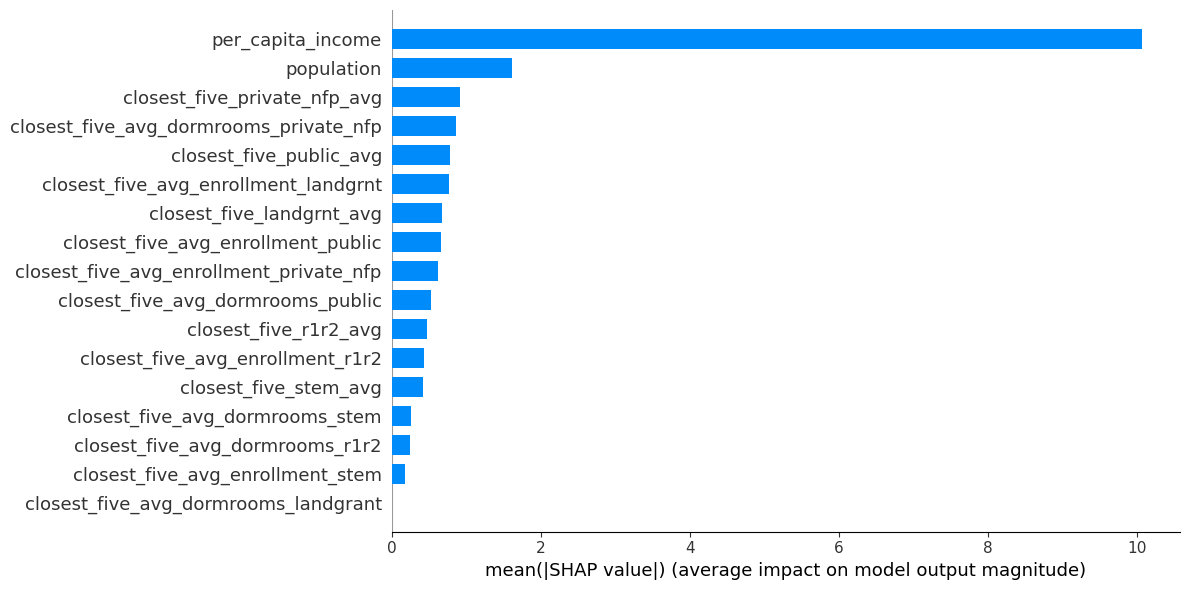

In [10]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X)

#### 
shap.summary_plot(
    shap_values, 
    X,
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
# Save the plot to a file
plt.savefig('data/Massachusetts/plot/shap_summary_plot_bar.png', bbox_inches='tight')
plt.show()
plt.close()

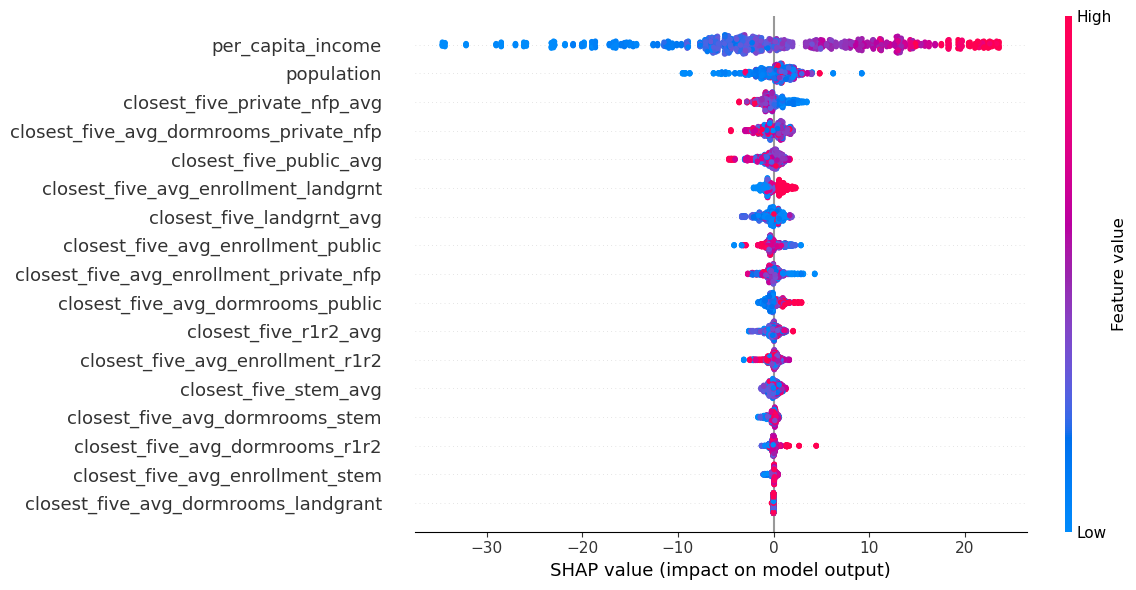

In [11]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X)

### the scatter plot
shap.summary_plot(
    shap_values, 
    X, 
    show=False, 
    plot_size=[12, 6])
plt.savefig('data/Massachusetts/plot/shap_summary_plot_density_scatter.png', bbox_inches='tight')
plt.show()
plt.close()

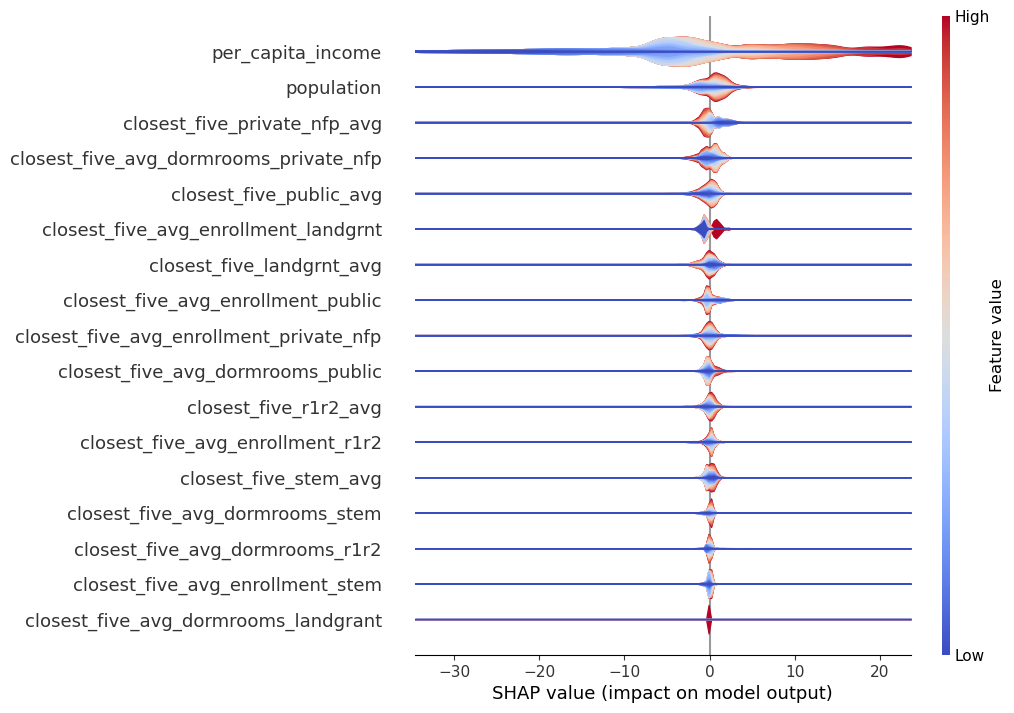

In [18]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X)

### The layered violin plot
shap.plots.violin(shap_values, 
                  features=X, 
                  feature_names=X.columns,
                  show=False,
                  plot_type="layered_violin")
plt.savefig('data/Massachusetts/plot/shap_summary_plot_layered_violin.png', bbox_inches='tight')
plt.show()
plt.close()

# Visualize a single prediction

In [13]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

In [14]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# Visualize many predictions

In [15]:
shap.force_plot(explainer.expected_value, shap_values[:X_test.shape[0], :], X_test.iloc[:X_test.shape[0], :])

# SHAP Dependence Plots

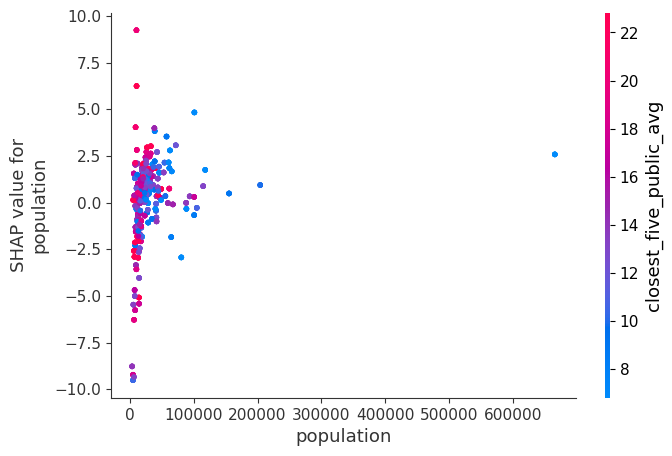

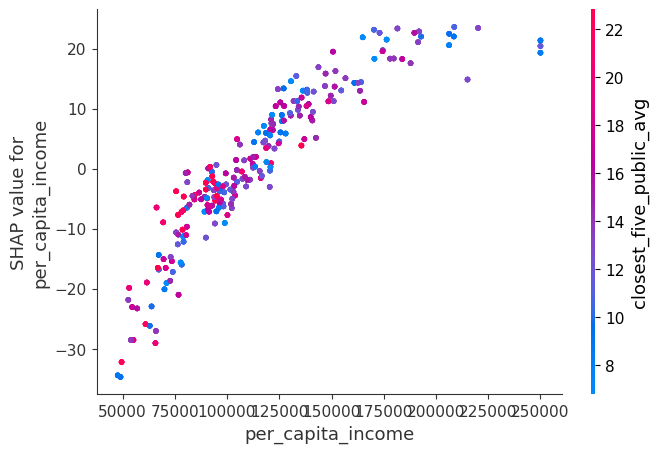

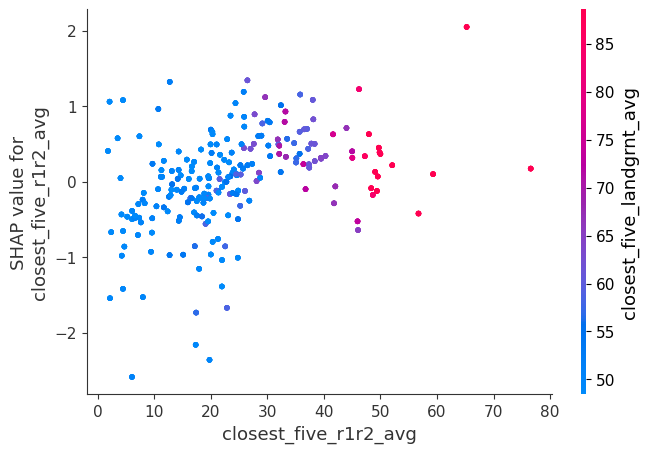

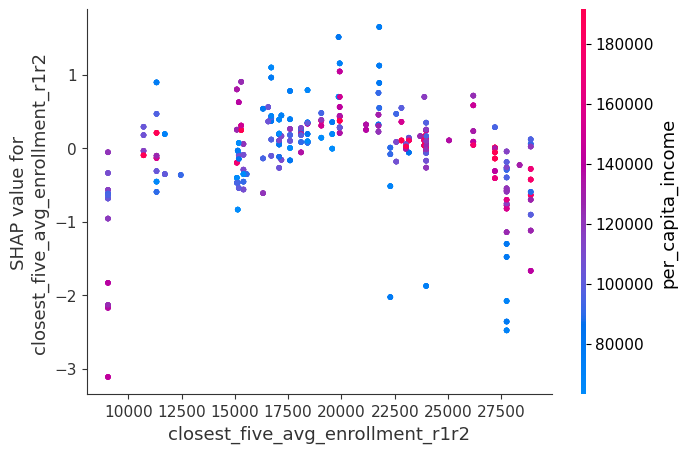

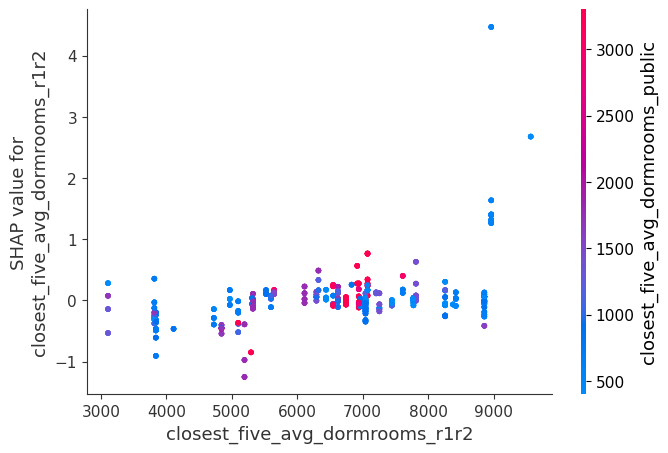

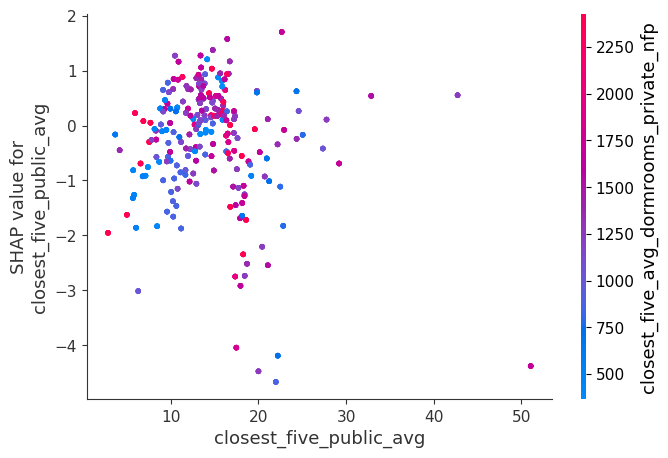

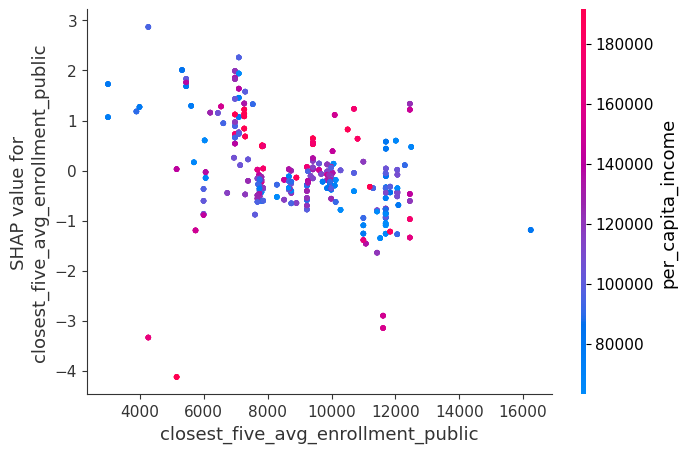

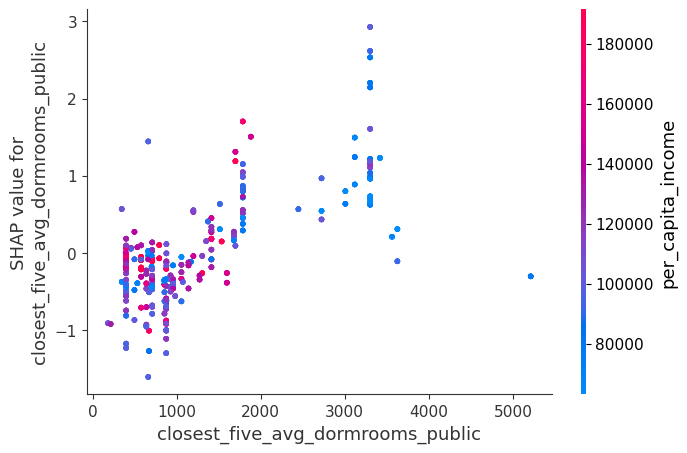

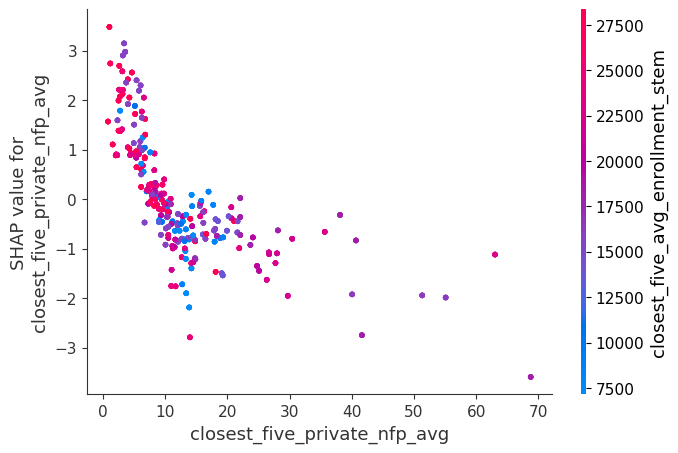

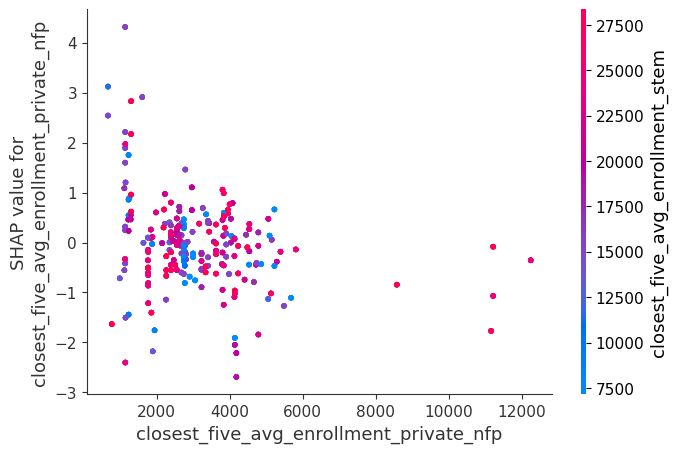

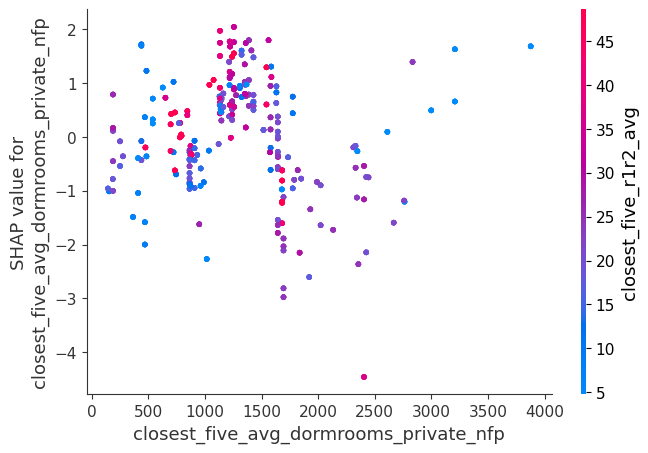

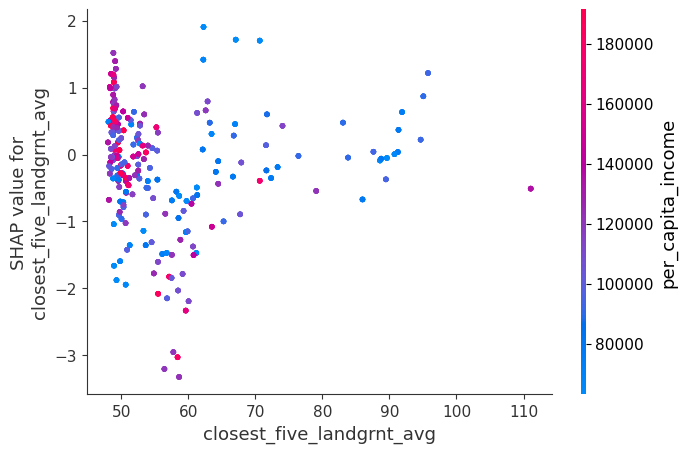

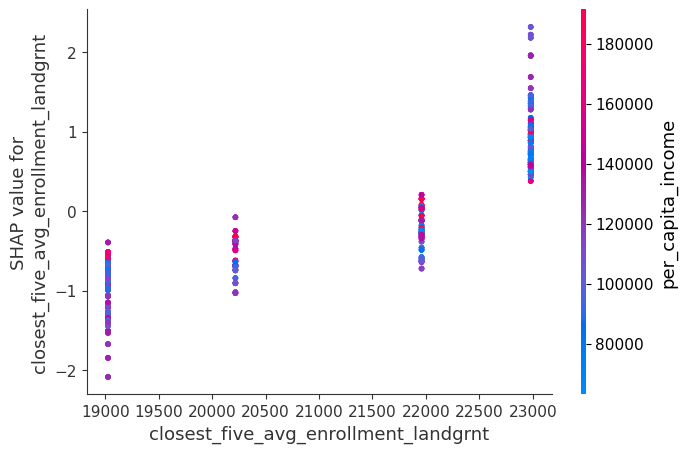

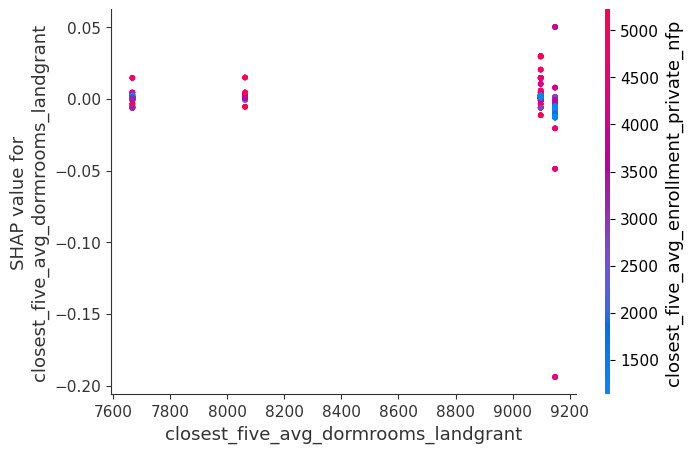

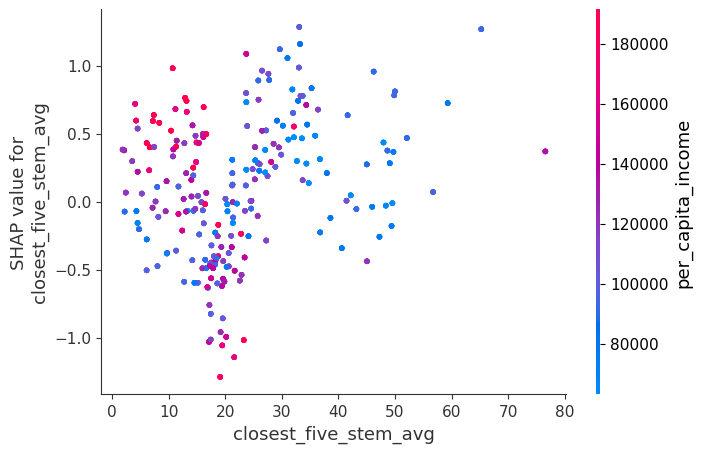

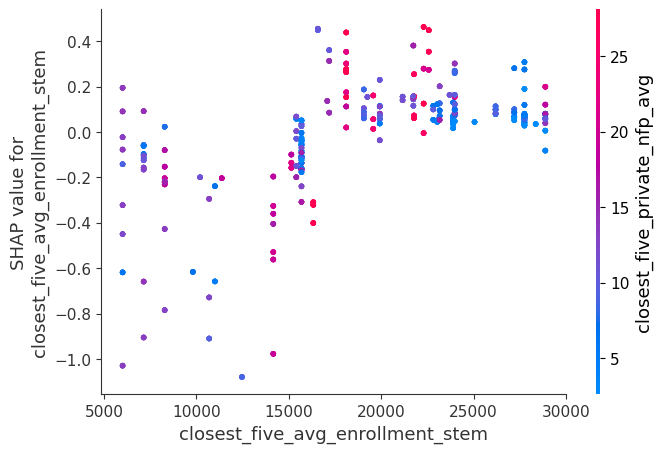

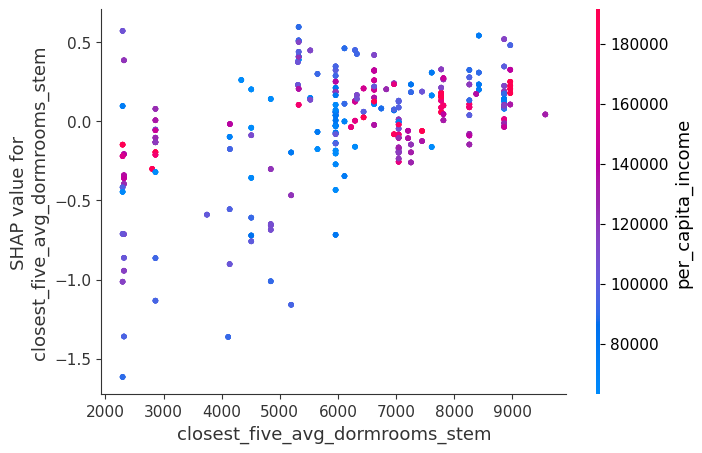

In [16]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X)

for name in X.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X, show=False)
    plt.savefig('data/Massachusetts/plot/shap_dependence_%s.pdf'%(name), bbox_inches='tight')
    plt.show()
    plt.close()